In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import copy

In [3]:
# Кастомный слой с отслеживанием пути
class PathAwareDense(Layer):
    def __init__(self, units, layer_id, activation='relu', **kwargs):
        super(PathAwareDense, self).__init__(**kwargs)
        self.units = units
        self.layer_id = layer_id
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        # Информационная ценность каждого нейрона
        self.neuron_value = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            trainable=False,
            name='neuron_value'
        )
        # Счетчик активаций
        self.activation_count = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=False,
            name='activation_count'
        )
        
    def call(self, inputs, training=None):
        # Вычисляем взвешенный выход
        output = tf.matmul(inputs, self.kernel * self.neuron_value) + self.bias
        activated_output = self.activation(output)
        
        if training:
            # Обновляем статистику активаций
            batch_activations = tf.reduce_mean(tf.cast(activated_output > 0.1, tf.float32), axis=0)
            self.activation_count.assign_add(batch_activations)
            
            # Обновляем информационную ценность на основе активаций и величины весов
            activation_ratio = self.activation_count / tf.reduce_max(self.activation_count)
            weight_magnitude = tf.reduce_mean(tf.abs(self.kernel), axis=0)
            
            # Комбинированная метрика информационной ценности
            new_value = 0.7 * activation_ratio + 0.3 * weight_magnitude
            self.neuron_value.assign(new_value)
        
        return activated_output

# Модель с поиском пути и стабилизацией
class PathAwareModel(Sequential):
    def __init__(self, stability_threshold=3, long_stability_threshold=10, **kwargs):
        super(PathAwareModel, self).__init__(**kwargs)
        self.layer_graph = nx.DiGraph()
        self.best_path = None
        self.path_strength = 0
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_losses = []
        self.val_losses = []
        self.path_strengths = []
        self.epoch_times = []
        self.samples_per_sec = []
        
        self.stability_threshold = stability_threshold
        self.long_stability_threshold = long_stability_threshold  # Порог длительной стабильности
        self.stability_counter = 0
        self.long_stability_counter = 0  # Счетчик длительной стабильности
        self.enhancement_epochs = []
        self.current_path_hash = None
        self.should_stop_training = False  # Флаг остановки обучения
        self.stop_reason = ""  # Причина остановки
        self.last_enhancement_epoch = -1  # Последняя эпоха усиления
        self.restart_count = 0  # Счетчик перезапусков
        self.max_restarts = 10  # Максимальное количество перезапусков
        
    def build_path_network(self):
        """Построение графа нейронной сети"""
        self.layer_graph.clear()
        
        # Добавляем узлы для входного слоя
        input_size = self.layers[0].kernel.shape[0]
        for i in range(input_size):
            self.layer_graph.add_node(f'input_{i}', value=1.0, layer=0)
        
        # Добавляем узлы и связи для скрытых слоев
        for layer_idx, layer in enumerate(self.layers):
            if hasattr(layer, 'neuron_value'):
                for neuron_idx in range(layer.units):
                    node_id = f'l{layer_idx}_n{neuron_idx}'
                    self.layer_graph.add_node(node_id, 
                                           value=layer.neuron_value[neuron_idx].numpy(),
                                           layer=layer_idx + 1)
                    
                    # Связи с предыдущим слоем
                    if layer_idx == 0:
                        # Связь с входным слоем
                        for prev_neuron in range(input_size):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.01:
                                self.layer_graph.add_edge(f'input_{prev_neuron}', node_id, 
                                                        weight=abs(weight))
                    else:
                        # Связь с предыдущим скрытым слоем
                        prev_layer = self.layers[layer_idx - 1]
                        for prev_neuron in range(prev_layer.units):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.01:
                                self.layer_graph.add_edge(f'l{layer_idx-1}_n{prev_neuron}', node_id, 
                                                        weight=abs(weight))
        
        # Добавляем выходной слой
        output_layer = self.layers[-1]
        for neuron_idx in range(output_layer.units):
            node_id = f'output_{neuron_idx}'
            self.layer_graph.add_node(node_id, value=1.0, layer=len(self.layers))
            
            # Связи с последним скрытым слоей
            last_hidden = self.layers[-2]
            for prev_neuron in range(last_hidden.units):
                weight = output_layer.kernel[prev_neuron, neuron_idx].numpy()
                if abs(weight) > 0.01:
                    self.layer_graph.add_edge(f'l{len(self.layers)-2}_n{prev_neuron}', node_id, 
                                            weight=abs(weight))
    
    def find_strongest_path(self):
        """Поиск наиболее сильного пути через сеть"""
        self.build_path_network()
        
        strongest_path = None
        max_strength = -1
        
        # Поиск путей от входных нейронов к выходным
        input_nodes = [n for n in self.layer_graph.nodes if self.layer_graph.nodes[n]['layer'] == 0]
        output_nodes = [n for n in self.layer_graph.nodes if self.layer_graph.nodes[n]['layer'] == len(self.layers)]
        
        for start_node in input_nodes:
            for end_node in output_nodes:
                try:
                    for path in nx.all_simple_paths(self.layer_graph, start_node, end_node):
                        path_strength = 1.0
                        for i in range(len(path) - 1):
                            edge_weight = self.layer_graph[path[i]][path[i+1]]['weight']
                            neuron_value = self.layer_graph.nodes[path[i+1]]['value']
                            path_strength *= edge_weight * neuron_value
                        
                        if path_strength > max_strength:
                            max_strength = path_strength
                            strongest_path = path
                except nx.NetworkXNoPath:
                    continue
        
        # Проверяем, изменился ли путь
        new_path_hash = hash(str(strongest_path)) if strongest_path else None
        path_changed = new_path_hash != self.current_path_hash
        
        if path_changed:
            # Проверяем условие остановки: потеря стабильности после длительной стабильности
            if self.long_stability_counter >= self.long_stability_threshold:
                self.should_stop_training = True
                self.stop_reason = f"Потеря стабильности после {self.long_stability_counter} эпох непрерывной стабильности"
            
            self.stability_counter = 0
            self.long_stability_counter = 0  # Сбрасываем счетчик длительной стабильности
            self.current_path_hash = new_path_hash
        else:
            self.stability_counter += 1
            self.long_stability_counter += 1  # Увеличиваем счетчик длительной стабильности
        
        self.best_path = strongest_path
        self.path_strength = max_strength
        return strongest_path, max_strength
    
    def enhance_path_weights(self, enhancement_factor=1.1):
        """Усиление весов вдоль найденного пути"""
        if self.best_path is None:
            return False
        
        for i in range(len(self.best_path) - 1):
            node_from = self.best_path[i]
            node_to = self.best_path[i+1]
            
            if 'l' in node_to:
                layer_idx = int(node_to.split('_')[0][1:])
                neuron_to_idx = int(node_to.split('_')[1][1:])
                
                if 'input' in node_from:
                    neuron_from_idx = int(node_from.split('_')[1])
                    current_weight = self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx]
                    enhanced_weight = current_weight * enhancement_factor
                    self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx].assign(enhanced_weight)
                else:
                    neuron_from_idx = int(node_from.split('_')[1][1:])
                    current_weight = self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx]
                    enhanced_weight = current_weight * enhancement_factor
                    self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx].assign(enhanced_weight)
        
        self.enhancement_epochs.append(len(self.train_accuracies))
        self.last_enhancement_epoch = len(self.train_accuracies)
        return True
    
    def add_layer_based_on_path_strength(self):
        """Добавление нового слоя на основе силы пути"""
        if self.path_strength <= 0:
            return False
        
        # Определяем количество нейронов в новом слое на основе силы пути
        base_neurons = 8
        strength_factor = min(3.0, max(0.5, self.path_strength * 10))
        new_neurons = int(base_neurons * strength_factor)
        
        print(f"💡 Добавляем новый слой с {new_neurons} нейронами (сила пути: {self.path_strength:.4f})")
        
        # Сохраняем текущие веса
        current_weights = []
        for layer in self.layers:
            if hasattr(layer, 'get_weights'):
                current_weights.append(layer.get_weights())
        
        # Создаем новую модель с дополнительным слоем
        new_model = PathAwareModel(
            stability_threshold=self.stability_threshold,
            long_stability_threshold=self.long_stability_threshold
        )
        
        # Добавляем все слои кроме выходного
        for i, layer in enumerate(self.layers[:-1]):
            if isinstance(layer, PathAwareDense):
                new_model.add(PathAwareDense(layer.units, layer_id=i, activation='relu'))
            else:
                new_model.add(Dense(layer.units, activation='relu'))
        
        # Добавляем новый слой
        new_model.add(PathAwareDense(new_neurons, layer_id=len(self.layers)-1, activation='relu'))
        
        # Добавляем выходной слой
        new_model.add(Dense(1, activation='sigmoid'))
        
        # Сначала строим модель, вызывая ее на небольшой порции данных
        dummy_input = X_train_final[:1]
        new_model(dummy_input)  # Это вызовет build() для всех слоев
        
        # Компилируем новую модель
        new_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
        
        # Восстанавливаем веса для существующих слоев
        for i in range(len(self.layers) - 1):
            if i < len(current_weights):
                new_model.layers[i].set_weights(current_weights[i])
        
        # Копируем историю обучения
        new_model.train_accuracies = self.train_accuracies.copy()
        new_model.val_accuracies = self.val_accuracies.copy()
        new_model.train_losses = self.train_losses.copy()
        new_model.val_losses = self.val_losses.copy()
        new_model.path_strengths = self.path_strengths.copy()
        new_model.epoch_times = self.epoch_times.copy()
        new_model.samples_per_sec = self.samples_per_sec.copy()
        new_model.enhancement_epochs = self.enhancement_epochs.copy()
        new_model.restart_count = self.restart_count + 1
        new_model.current_path_hash = self.current_path_hash
        new_model.stability_counter = 0
        new_model.long_stability_counter = 0
        new_model.last_enhancement_epoch = self.last_enhancement_epoch
        
        return new_model

In [4]:
# Генерация данных
#X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, 
#                          n_informative=12, n_redundant=8, random_state=123)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                    random_state=123, stratify=y)

#, X_val, y_train_final, y_val = train_test_split(X_train, y_train, 
#                                                             test_size=0.2, 
#                                                             random_state=42, 
#                                                             stratify=y_train)

In [5]:
# Параметры генерации
n_samples = 1000
n_features = 20
n_classes = 2

# Генерация случайных данных с равномерным распределением
# Особенности (X) - равномерное распределение от -1 до 1
X = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, n_features))

# Целевая переменная (y) - случайные метки классов 0 и 1
y = np.random.randint(0, n_classes, size=n_samples)

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=123, stratify=y)

# Дальнейшее разделение тренировочной выборки
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, 
                                                             test_size=0.2, 
                                                             random_state=42, 
                                                             stratify=y_train)

# Проверка формы данных
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X shape: (1000, 20)
y shape: (1000,)
X_train_final shape: (640, 20)
X_val shape: (160, 20)
X_test shape: (200, 20)


C:\cygwin64\tmp\ipykernel_7544\596176158.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(PathAwareDense, self).__init__(**kwargs)



=== ОБУЧЕНИЕ С МОНИТОРИНГОМ СКОРОСТИ И АВТОМАТИЧЕСКИМ УДАЛЕНИЕМ СЛОЕВ ===
Максимальное количество перезапусков: 20
Порог снижения скорости: 20.0%
Минимальная скорость: 400.0 samples/sec
Проверка скорости каждые: 3 эпох

Эпоха 1/500 (Перезапуск #0, Batch: 16)
Время: 1.28 сек
Скорость: 500.6 образцов/сек
Сила пути: 0.1011
Стабильность: 0/6 эпох
Длительная стабильность: 0/6 эпох
Точность: 0.4984

Эпоха 2/500 (Перезапуск #0, Batch: 16)
Время: 0.24 сек
Скорость: 2619.6 образцов/сек
Сила пути: 0.0993
Стабильность: 1/6 эпох
Длительная стабильность: 1/6 эпох
Точность: 0.5078

Эпоха 3/500 (Перезапуск #0, Batch: 16)
Время: 0.25 сек
Скорость: 2565.2 образцов/сек
Сила пути: 0.1001
Стабильность: 2/6 эпох
Длительная стабильность: 2/6 эпох
Точность: 0.5109

Эпоха 4/500 (Перезапуск #0, Batch: 16)
Время: 0.31 сек
Скорость: 2091.0 образцов/сек
Сила пути: 0.0996
Стабильность: 3/6 эпох
Длительная стабильность: 3/6 эпох
Точность: 0.5109

Эпоха 5/500 (Перезапуск #0, Batch: 16)
Время: 0.22 сек
Скорость: 284

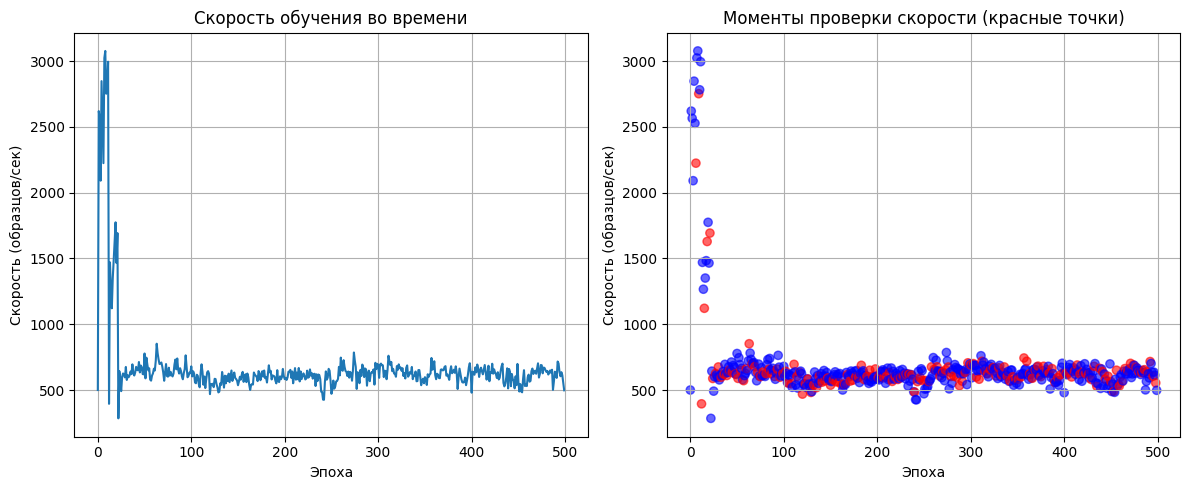

In [6]:
# Определение гиперпараметров
STABILITY_THRESHOLD = 6
LONG_STABILITY_THRESHOLD = 6
INITIAL_BATCH_SIZE = 16
MAX_BATCH_SIZE = 512
BATCH_SIZE_GROWTH_FACTOR = 2
SPEED_DECREASE_THRESHOLD = 0.2  # Порог снижения скорости обучения (20%)
MIN_SPEED_THRESHOLD = 400.0  # Минимальная допустимая скорость (образцов/сек)
LAYER_REMOVAL_CHECK_EPOCHS = 3  # Проверять скорость каждые N эпох
TOTAL_EPOCHS = 500
MAX_RESTARTS = 20
MAX_LAYER_REMOVALS = 30

# Функция для создания начальной модели
def create_initial_model():
    model = PathAwareModel(stability_threshold=STABILITY_THRESHOLD, 
                          long_stability_threshold=LONG_STABILITY_THRESHOLD)
    model.add(PathAwareDense(12, layer_id=0, input_dim=X_train.shape[1], activation='relu'))
    model.add(PathAwareDense(8, layer_id=1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Функция для удаления первого скрытого слоя
def remove_first_hidden_layer(model):
    """Удаляет первый скрытый слой и возвращает новую модель"""
    if len(model.layers) <= 2:  # Минимум: входной + выходной слои
        print("❌ Нельзя удалить слой: минимальная архитектура достигнута")
        return None
    
    print(f"🗑️ Удаляем первый скрытый слой из-за низкой скорости обучения")
    
    # Сохраняем текущие веса
    current_weights = []
    for layer in model.layers:
        if hasattr(layer, 'get_weights'):
            current_weights.append(layer.get_weights())
    
    # Создаем новую модель с правильной архитектурой
    new_model = PathAwareModel(
        stability_threshold=model.stability_threshold,
        long_stability_threshold=model.long_stability_threshold
    )
    
    # Определяем новую архитектуру: пропускаем первый скрытый слой
    # Но нам нужно правильно обработать входной размер
    
    # Добавляем оставшиеся слои, начиная со второго
    for i, layer in enumerate(model.layers[1:], 0):
        if isinstance(layer, PathAwareDense):
            if i == 0:  # Первый слой в новой модели (бывший второй)
                # Для первого слоя указываем правильный input_dim
                new_model.add(PathAwareDense(layer.units, layer_id=0, 
                                           input_dim=X_train.shape[1], activation='relu'))
            else:
                new_model.add(PathAwareDense(layer.units, layer_id=i, activation='relu'))
        else:
            new_model.add(Dense(layer.units, activation=layer.activation.__name__))
    
    # Строим модель
    dummy_input = X_train_final[:1]
    _ = new_model(dummy_input)
    
    # Компилируем модель
    new_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    
    # Правильно перенастраиваем веса
    # Для первого слоя новой модели нам нужно адаптировать веса
    if len(current_weights) >= 2:
        # Веса второго слоя оригинальной модели
        second_layer_weights = current_weights[1]
        
        # Для PathAwareDense берем только kernel и bias
        if isinstance(new_model.layers[0], PathAwareDense):
            # Создаем новые веса с правильной формой
            new_weights = new_model.layers[0].get_weights()
            # kernel должен быть формы (input_dim, units)
            # Мы не можем просто скопировать веса, так как размерности не совпадают
            # Поэтому инициализируем заново и добавляем небольшой шум к существующим весам
            input_dim = X_train.shape[1]
            units = new_model.layers[0].units
            
            # Создаем случайные веса с учетом оригинального распределения
            if len(second_layer_weights) >= 2:
                original_kernel = second_layer_weights[0]
                original_bias = second_layer_weights[1]
                
                # Адаптируем kernel - берем среднее значение оригинального kernel
                # и создаем новые веса с тем же средним
                mean_weight = np.mean(original_kernel)
                std_weight = np.std(original_kernel)
                
                new_kernel = np.random.normal(mean_weight, std_weight, 
                                            (input_dim, units))
                new_bias = original_bias.copy()
                
                new_weights[0] = new_kernel
                new_weights[1] = new_bias
                new_model.layers[0].set_weights(new_weights)
        
        # Для остальных слоев просто копируем веса
        for i in range(1, len(new_model.layers)):
            if i < len(current_weights) - 1:
                new_model.layers[i].set_weights(current_weights[i + 1])
    
    # Копируем историю обучения
    new_model.train_accuracies = model.train_accuracies.copy()
    new_model.val_accuracies = model.val_accuracies.copy()
    new_model.train_losses = model.train_losses.copy()
    new_model.val_losses = model.val_losses.copy()
    new_model.path_strengths = model.path_strengths.copy()
    new_model.epoch_times = model.epoch_times.copy()
    new_model.samples_per_sec = model.samples_per_sec.copy()
    new_model.enhancement_epochs = model.enhancement_epochs.copy()
    new_model.restart_count = model.restart_count
    new_model.current_path_hash = None
    new_model.stability_counter = 0
    new_model.long_stability_counter = 0
    new_model.last_enhancement_epoch = -1
    
    print(f"✅ Новая архитектура: {len(new_model.layers) - 1} скрытых слоев")
    for i, layer in enumerate(new_model.layers[:-1]):
        if hasattr(layer, 'units'):
            print(f"  Слой {i}: {layer.units} нейронов")
    
    return new_model

# Функция для проверки скорости обучения
def check_learning_speed(model, current_epoch):
    """Проверяет скорость обучения и возвращает True если нужно удалить слой"""
    if len(model.samples_per_sec) < LAYER_REMOVAL_CHECK_EPOCHS + 1:
        return False
    
    # Берем последние N значений скорости
    recent_speeds = model.samples_per_sec[-LAYER_REMOVAL_CHECK_EPOCHS:]
    previous_speeds = model.samples_per_sec[-(LAYER_REMOVAL_CHECK_EPOCHS*2):-LAYER_REMOVAL_CHECK_EPOCHS]
    
    if not previous_speeds or not recent_speeds:
        return False
    
    avg_recent_speed = np.mean(recent_speeds)
    avg_previous_speed = np.mean(previous_speeds)
    
    # Проверяем условия для удаления слоя
    speed_decreased = avg_recent_speed < avg_previous_speed * SPEED_DECREASE_THRESHOLD
    speed_too_low = avg_recent_speed < MIN_SPEED_THRESHOLD
    
    # Не удаляем слои слишком часто - минимум 10 эпох между проверками
    min_epochs_between_removals = 10
    last_removal_epoch = getattr(model, '_last_removal_epoch', -min_epochs_between_removals)
    can_remove_again = current_epoch - last_removal_epoch >= min_epochs_between_removals
    
    print(f"📊 Мониторинг скорости: {avg_recent_speed:.1f} samples/sec "
          f"(было {avg_previous_speed:.1f}, изменение: {avg_recent_speed/avg_previous_speed:.1%})")
    
    return (speed_decreased or speed_too_low) and can_remove_again

# Основной цикл обучения с перезапусками и мониторингом скорости
model = create_initial_model()
max_restarts = MAX_RESTARTS
total_epochs = TOTAL_EPOCHS

print("=== ОБУЧЕНИЕ С МОНИТОРИНГОМ СКОРОСТИ И АВТОМАТИЧЕСКИМ УДАЛЕНИЕМ СЛОЕВ ===")
print(f"Максимальное количество перезапусков: {max_restarts}")
print(f"Порог снижения скорости: {SPEED_DECREASE_THRESHOLD*100}%")
print(f"Минимальная скорость: {MIN_SPEED_THRESHOLD} samples/sec")
print(f"Проверка скорости каждые: {LAYER_REMOVAL_CHECK_EPOCHS} эпох")

restart_count = 0
layer_removal_count = 0
max_layer_removals = MAX_LAYER_REMOVALS  # Максимальное количество удалений слоев

while restart_count <= max_restarts and layer_removal_count <= max_layer_removals:
    # Рассчитываем размер батча для текущего перезапуска
    current_batch_size = int(INITIAL_BATCH_SIZE * (BATCH_SIZE_GROWTH_FACTOR ** restart_count))
    if current_batch_size < MAX_BATCH_SIZE:
        current_batch_size = min(current_batch_size, len(X_train_final))
    else:
        current_batch_size = MAX_BATCH_SIZE
    
    if restart_count > 0:
        print(f"\n🔄 ПЕРЕЗАПУСК #{restart_count}")
        print(f"Текущая архитектура: {len(model.layers) - 1} скрытых слоев")
        print(f"Размер батча: {current_batch_size}")
        for i, layer in enumerate(model.layers[:-1]):
            if hasattr(layer, 'units'):
                print(f"  Слой {i}: {layer.units} нейронов")
    
    # Сбрасываем флаг остановки для нового запуска
    model.should_stop_training = False
    model.stop_reason = ""
    
    start_epoch = len(model.train_accuracies)
    for epoch in range(start_epoch, total_epochs):
        if model.should_stop_training:
            print(f"\n🛑 ОСТАНОВКА ОБУЧЕНИЯ: {model.stop_reason}")
            break
            
        print(f"\nЭпоха {epoch + 1}/{total_epochs} (Перезапуск #{restart_count}, Batch: {current_batch_size})")
        start = time.time()
        
        # Обучаем модель с текущим размером батча
        history = model.fit(X_train_final, y_train_final,
                           epochs=1,
                           batch_size=current_batch_size,
                           validation_data=(X_val, y_val),
                           verbose=0)
        
        # Сохраняем метрики
        model.train_accuracies.append(history.history['accuracy'][0])
        model.val_accuracies.append(history.history['val_accuracy'][0])
        model.train_losses.append(history.history['loss'][0])
        model.val_losses.append(history.history['val_loss'][0])
        
        # Поиск пути
        best_path, path_strength = model.find_strongest_path()
        model.path_strengths.append(path_strength)
        
        # Автоматическое усиление
        current_epoch_count = len(model.train_accuracies)
        if (model.stability_counter >= STABILITY_THRESHOLD and 
            best_path is not None and
            current_epoch_count - model.last_enhancement_epoch >= STABILITY_THRESHOLD):
            print(f"🚀 АВТОМАТИЧЕСКОЕ УСИЛЕНИЕ! Путь стабилен {model.stability_counter} эпох")
            model.enhance_path_weights(enhancement_factor=1.02)
            print("✅ Веса усилены")
        
        duration = time.time() - start
        model.epoch_times.append(duration)
        current_speed = len(X_train_final) / duration
        model.samples_per_sec.append(current_speed)
        
        print(f"Время: {duration:.2f} сек")
        print(f"Скорость: {current_speed:.1f} образцов/сек")
        if best_path:
            print(f"Сила пути: {path_strength:.4f}")
            print(f"Стабильность: {model.stability_counter}/{STABILITY_THRESHOLD} эпох")
            print(f"Длительная стабильность: {model.long_stability_counter}/{LONG_STABILITY_THRESHOLD} эпох")
        print(f"Точность: {model.train_accuracies[-1]:.4f}")
        if model.train_accuracies[-1] == 1:
            print("Точность тренировочных данных достигла порога переобучения")
            break
        if model.evaluate(X_test, y_test, verbose=0)[1] >= 0.94:
            print("Достигнута оптимальная точность в 0.94")
            break
        
        # Проверяем скорость обучения каждые N эпох
        if (current_epoch_count % LAYER_REMOVAL_CHECK_EPOCHS == 0 and 
            current_epoch_count >= LAYER_REMOVAL_CHECK_EPOCHS * 2):
            
            if check_learning_speed(model, current_epoch_count):
                print(f"⚠️ ОБНАРУЖЕНО СНИЖЕНИЕ СКОРОСТИ ОБУЧЕНИЯ!")
                print("🔄 Запускаем процесс оптимизации архитектуры...")
                break
    
    # Проверяем, нужно ли удалить слой из-за низкой скорости
    if (len(model.samples_per_sec) >= LAYER_REMOVAL_CHECK_EPOCHS * 2 and
        check_learning_speed(model, len(model.train_accuracies))):
        
        new_model = remove_first_hidden_layer(model)
        # В основном цикле, после успешного удаления слоя:
        if new_model:
            model = new_model
            layer_removal_count += 1
            model._last_removal_epoch = len(model.train_accuracies)  # Запоминаем эпоху удаления
            print(f"✅ Удалено слоев: {layer_removal_count}/{max_layer_removals}")
            continue  # Продолжаем с новой архитектурой
    
    # Если обучение не было остановлено досрочно, выходим из цикла перезапусков
    if not model.should_stop_training:
        print(f"\n✅ Обучение завершено без досрочной остановки")
        break
    
    # Если достигли максимального количества перезапусков
    if restart_count >= max_restarts:
        print(f"\n⚠️ Достигнуто максимальное количество перезапусков ({max_restarts})")
        break
    
    # Создаем новую модель с дополнительным слоем
    new_model = model.add_layer_based_on_path_strength()
    if new_model:
        model = new_model
        restart_count += 1
    else:
        print("❌ Не удалось добавить новый слой")
        break

# Финальные результаты
print(f"\n=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ===")
print(f"Количество перезапусков: {restart_count}")
print(f"Количество удаленных слоев: {layer_removal_count}")
print(f"Финальная архитектура: {len(model.layers) - 1} скрытых слоев")
print(f"Финальный размер батча: {current_batch_size}")
for i, layer in enumerate(model.layers[:-1]):
    if hasattr(layer, 'units'):
        print(f"  Слой {i}: {layer.units} нейронов")

final_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Финальная точность на тесте: {final_accuracy:.4f}")

# Визуализация скорости обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.samples_per_sec)
plt.xlabel('Эпоха')
plt.ylabel('Скорость (образцов/сек)')
plt.title('Скорость обучения во времени')
plt.grid(True)

plt.subplot(1, 2, 2)
# Отмечаем моменты удаления слоев
colors = ['blue'] * len(model.samples_per_sec)
for i in range(len(model.samples_per_sec)):
    if i % LAYER_REMOVAL_CHECK_EPOCHS == 0 and i >= LAYER_REMOVAL_CHECK_EPOCHS * 2:
        colors[i] = 'red'

plt.scatter(range(len(model.samples_per_sec)), model.samples_per_sec, 
           c=colors, alpha=0.6)
plt.xlabel('Эпоха')
plt.ylabel('Скорость (образцов/сек)')
plt.title('Моменты проверки скорости (красные точки)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Результаты
print(f"\n=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ===")
print(f"Количество перезапусков: {restart_count}")
print(f"Финальная архитектура: {len(model.layers) - 1} скрытых слоев")
print(f"Финальный размер батча: {current_batch_size}")
for i, layer in enumerate(model.layers[:-1]):
    if hasattr(layer, 'units'):
        print(f"  Слой {i}: {layer.units} нейронов")
print(f"Усиления произведены на эпохах: {model.enhancement_epochs}")
print(f"Общее количество усилений: {len(model.enhancement_epochs)}")

final_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Финальная точность на тесте: {final_accuracy:.4f}")


=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ===
Количество перезапусков: 2
Финальная архитектура: 4 скрытых слоев
Финальный размер батча: 64
  Слой 0: 12 нейронов
  Слой 1: 8 нейронов
  Слой 2: 8 нейронов
  Слой 3: 4 нейронов
Усиления произведены на эпохах: [7, 19, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95, 101, 107, 113, 119, 125, 131, 137, 143, 149, 155, 161, 167, 173, 179, 185, 191, 197, 203, 209, 215, 221, 227, 233, 239, 245, 251, 257, 263, 269, 275, 281, 287, 293, 299, 305, 311, 317, 323, 329, 335, 341, 347, 353, 359, 365, 371, 377, 383, 389, 395, 401, 407, 413, 419, 425, 431, 437, 443, 449, 455, 461, 467, 473, 479, 485, 491, 497]
Общее количество усилений: 81
Финальная точность на тесте: 0.5500


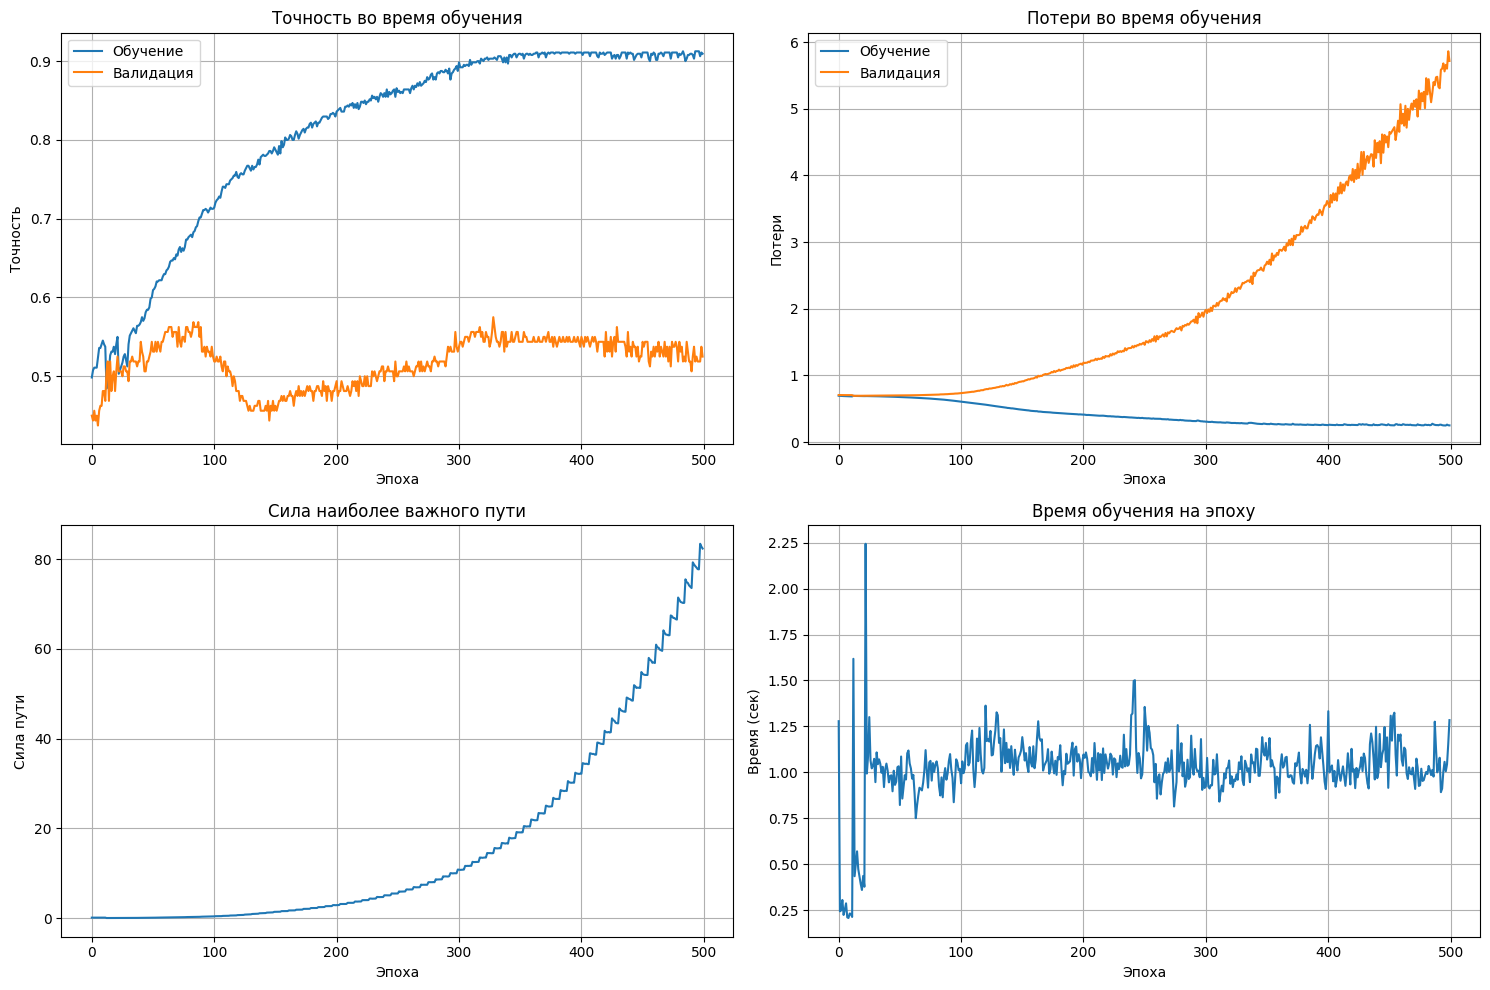


=== ИНФОРМАЦИЯ О ПЕРЕЗАПУСКАХ ===
Всего эпох обучения: 500
Количество перезапусков: 2


In [8]:
# Визуализация процесса обучения
plt.figure(figsize=(15, 10))

# График точности
plt.subplot(2, 2, 1)
plt.plot(model.train_accuracies, label='Обучение')
plt.plot(model.val_accuracies, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность во время обучения')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(2, 2, 2)
plt.plot(model.train_losses, label='Обучение')
plt.plot(model.val_losses, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери во время обучения')
plt.legend()
plt.grid(True)

# График силы пути
plt.subplot(2, 2, 3)
plt.plot(model.path_strengths)
plt.xlabel('Эпоха')
plt.ylabel('Сила пути')
plt.title('Сила наиболее важного пути')
plt.grid(True)

# График времени обучения
plt.subplot(2, 2, 4)
plt.plot(model.epoch_times)
plt.xlabel('Эпоха')
plt.ylabel('Время (сек)')
plt.title('Время обучения на эпоху')
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод информации о перезапусках
print(f"\n=== ИНФОРМАЦИЯ О ПЕРЕЗАПУСКАХ ===")
print(f"Всего эпох обучения: {len(model.train_accuracies)}")
print(f"Количество перезапусков: {model.restart_count}")